In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

In [ ]:
#read dataset
original_dms_data = pd.read_csv('/Users/liza/Desktop/Bioinfo Project/DMS_data/GFP_AEQVI_Sarkisyan_2016.csv')
# split first column of df into multiple columns
original_dms_data_col = original_dms_data
only_mutants = original_dms_data["mutant"].to_frame()
original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)

PREPARE DATASET FOR RANKING CALCULATION:
1. how many mutations does each mutant have? -> mut_count (df_mutation_count)
2. find out all possible mutations -> all_possible_mutations
3. df mutations x mutants -> which mutants contain which mutations -> result_how_often
4. plots + calculation variance x how many values used for variance per mutation count
-> variance of all fscores of all mutants containing mutation X shows how constant the effect of the mutation is


In [3]:
# count how many mutations each mutant has
list_mut_count_in_progress = []
for i in range(len(original_dms_data['mutant'])):
    list_mut_count_in_progress.append(original_dms_data['mutant'].iloc[i].count(':'))
list_mut_count_prae = np.array(list_mut_count_in_progress)
list_mut_count = (list_mut_count_prae + 1)
df_mutation_counts = pd.DataFrame(list_mut_count)

In [4]:
#concat mutation_count to original df
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")

working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)
working_dataframe.head()

,DMS_score,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,mut_count
0,1.301030,K3R,V55A,Q94R,A110T,D117G,M153K,D216A,None,None,None,None,None,None,None,None,7
1,3.137350,K3Q,V16A,I167T,L195Q,None,None,None,None,None,None,None,None,None,None,None,4
2,1.553913,K3Q,Y143C,N164D,S205P,A227T,None,None,None,None,None,None,None,None,None,None,5
3,3.404237,K3Q,Y143N,V193A,None,None,None,None,None,None,None,None,None,None,None,None,3
4,3.738586,K3R,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1


In [5]:
#all existing mutations in one list: calculation of all_possible_mutations

working_dataframe_only_ms = working_dataframe.loc[:, ["m1", "m2", "m3", 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']]
all_possible_mutations = working_dataframe_only_ms.values.flatten().tolist()
all_possible_mutations = list(set(all_possible_mutations))
#"none" is also a value in the list -> remove
while None in all_possible_mutations:
    all_possible_mutations.remove(None)
only_mutants_list = only_mutants['mutant']


In [6]:
#remodel df so it is more convenient
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)


In [7]:
#df which mutant from only_mutants_list contains the mutations from all_possible_mutations
list_of_dfs = []

# For-Loop zum Erstellen und Hinzufügen eines neuen Columns in jedem Durchlauf
for i in all_possible_mutations:
    new_column_name = f'{i}'
    new_column_values = [only_mutants_list.str.contains(i, regex= False)]
    new_df = pd.DataFrame({new_column_name: new_column_values})
    new_df_exploded = new_df.explode(new_column_name)
    list_of_dfs.append(new_df_exploded)

# concat dfs from the list
result_how_often = pd.concat(list_of_dfs, axis=1)
result_how_often = result_how_often.reset_index(drop=True)

## result_how_often.to_csv('dataframe_mutanten_Mutationen.csv', index=True)

In [8]:
# more convenient df (just mutcount und fscore)
count_fscore_frame = working_dataframe[['DMS_score', 'mut_count']]

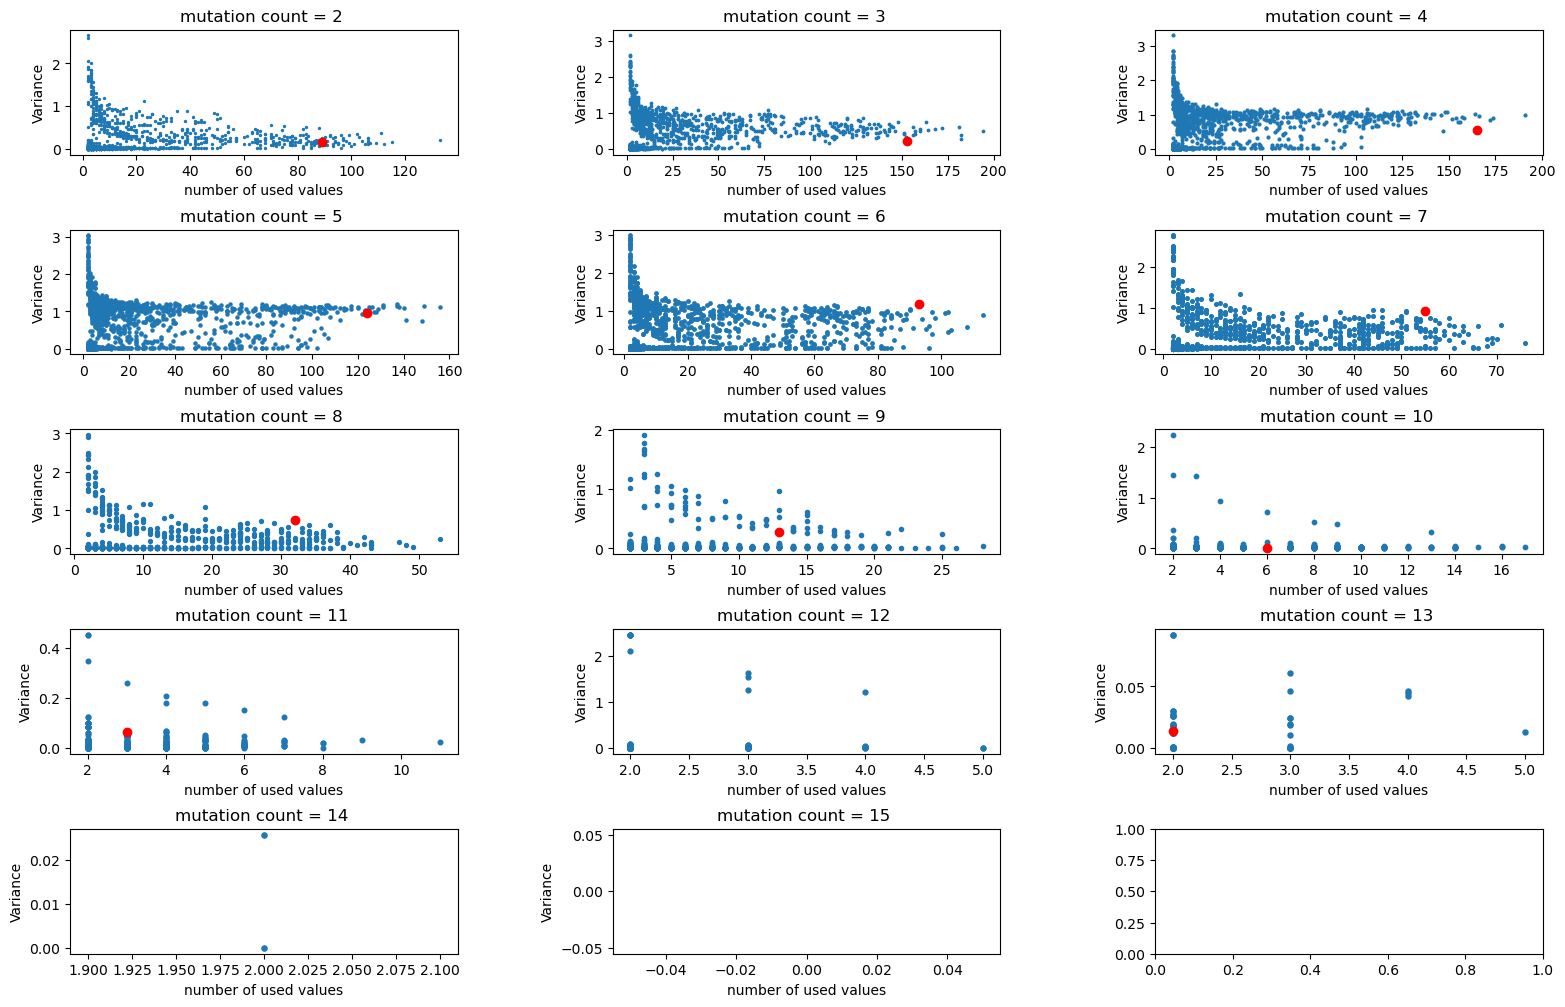

In [45]:
#plot: variance of fscores per mutation count and number of values uesed for variance calculation
#-> bottom right corner is the best, because the varaince is the most reliable

import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(19, 12))  # Abbildung und Achsenobjekte erstellen
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for j, ax in zip(range(2, 16), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()
        variance_per_mutant_list.append(varianz_mut)

    variance_per_mutant_series = pd.Series(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_df = variance_per_mutant_series.to_frame()


#how reliable is the calculated variance? -> how many values are available for the calculation

    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_for_variance = pd.Series(how_many_for_variance, index=all_possible_mutations)
    how_many_for_variance_df = how_many_for_variance.to_frame()


    how_many_AND_variance_df = pd.concat([how_many_for_variance_df, variance_per_mutant_df], axis = 1)
    how_many_AND_variance_df.columns = ['number of used values', 'Variance']
    how_many_AND_variance_df = how_many_AND_variance_df.dropna()

#scatter plot variance x count
    ax.scatter(how_many_AND_variance_df['number of used values'],how_many_AND_variance_df['Variance'], s = j )
    ax.set_xlabel('number of used values')
    ax.set_ylabel('Variance')

    if "V163A" in how_many_AND_variance_df.index:
        ax.scatter(how_many_AND_variance_df['number of used values']['V163A'],how_many_AND_variance_df['Variance']['V163A'], c='red')
    ax.set_title(f'mutation count = {j} ')



FURTHER PREPARATION FOR RANKINGS:
1. variance calculation per mutant (not-weighted)
2. how many values got used for the calculation, same as above but for every mutcount combined
-> both in one dataframe
3. calculate df that contains the difference between the fscore-means of all mutants WITH mutation X and WITHOUT mutation X
-> how big is the effect of the mutation on existing in general
-> not weighted

In [10]:
#variance means, calculate variances per mutation per mutation count -> mean of all per mutation
#-> not yet weighted

frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# IMPORTANT!! -> only values from mutants with up to 7 mutations (mut_count < 7), because the fscores from mutants with a mut_counts above 7 are generally low (-> boxplot from statistical_test_fscores)
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# df variance per mutatuion (rows) per mutation_count (columns)
variance_per_mutant_count_df
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/1098898036.py:18: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [12]:
how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 8), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/2598593114.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [13]:
combined_means_variance_how_many = pd.concat([mean_variances_per_mutations, mean_how_many_per_mutations], axis=1)
combined_means_variance_how_many.columns = ['mean_variances_per_mutations', 'mean_how_many_per_mutations']

In [25]:
#differences calculated (effect of mutation X on the fscore)
nur_fscore_mut_count = working_dataframe.loc[:, ["DMS_score", "mut_count"]]
differences_list = []

for i in all_possible_mutations:
    #for all mutants WITH the mutation
    #filter the mutants for the existing of mutation X (-> result_how_often)
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index
    #fscores from all mutants that match
    only_rows_with_mut = nur_fscore_mut_count [(nur_fscore_mut_count ['mut_count'] >2) & (nur_fscore_mut_count .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_only_mut = only_rows_with_mut['DMS_score'].mean()
#-------------
    #for all mutants WITHOUT the mutation (same calculation)
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_every_but_mut = only_rows_withOUT_mut['DMS_score'].mean()
#----------------
    difference_means = mean_dms_score_only_mut - mean_dms_score_every_but_mut
    differences_list.append(difference_means)

all_differences_means = pd.DataFrame({'Difference': differences_list}, index=all_possible_mutations)


----------------RANKING 0:
-> ranked by variance (without taking into account how many values got used for the calculation)

In [14]:
sorted_Ranking0 = combined_means_variance_how_many.sort_values(by='mean_variances_per_mutations')

sorted_Ranking0

,mean_variances_per_mutations,mean_how_many_per_mutations
Y66S,1.264636e-14,1.333333
M233S,7.899120e-14,0.500000
A110P,8.391788e-14,1.000000
A206P,1.307599e-13,0.666667
F100P,1.963388e-13,0.666667
...,...,...
N121L,NaN,0.166667
Q184W,NaN,0.333333
E32M,NaN,0.166667
S175D,NaN,0.166667


In [46]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking0= sorted_Ranking0.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking0.html', 'w') as file:
    file.write(styled_ranking0.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/1720088858.py:14: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking0.render())


----------------RANKING 1: (that was the try if the ranking-function works)
-> ranked by the available values for each mutation (how often does mutation X appear in total)

In [1]:
sorted_Ranking1 = combined_means_variance_how_many.sort_values(by='mean_how_many_per_mutations', ascending= False)

print(sorted_Ranking1)

NameError: name 'combined_means_variance_how_many' is not defined

In [47]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking1= sorted_Ranking1.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking1.html', 'w') as file:
    file.write(styled_ranking1.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/1162886222.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking1.render())






----------------RANKING 1a:
-> ranked by a rank_score build from the variance and the count of available mutations
-> combination of ranking 0 and 1

In [26]:
combined_means_variance_how_many['Rank'] = combined_means_variance_how_many['mean_variances_per_mutations'].rank(ascending=False) - combined_means_variance_how_many['mean_how_many_per_mutations'].rank()

sorted_Ranking1a = combined_means_variance_how_many.sort_values(by='Rank')

print(sorted_Ranking1a)

       mean_variances_per_mutations  mean_how_many_per_mutations    Rank
K107R                      0.796342                    92.833333 -1545.0
D190G                      0.791333                    90.166667 -1533.0
D117G                      0.761510                    99.833333 -1516.0
N164D                      0.750293                   102.833333 -1506.5
T9A                        0.760585                    87.500000 -1483.0
...                             ...                          ...     ...
N121L                           NaN                     0.166667     NaN
Q184W                           NaN                     0.333333     NaN
E32M                            NaN                     0.166667     NaN
S175D                           NaN                     0.166667     NaN
H217F                           NaN                     0.166667     NaN

[1810 rows x 3 columns]


In [27]:
#same ranking just with only the stabilizing (Difference > 0)
condition = all_differences_means['Difference'] > 0
sorted_only_stab_Ranking1a = sorted_Ranking1a.drop(all_differences_means.loc[condition].index)
print(sorted_only_stab_Ranking1a)


       mean_variances_per_mutations  mean_how_many_per_mutations    Rank
N185S                      0.713168                   103.500000 -1429.0
T225A                      0.721625                    96.500000 -1427.0
N149S                      0.708680                    87.833333 -1379.0
M88L                       0.790748                    51.500000 -1377.0
K209R                      0.684093                    97.666667 -1347.0
...                             ...                          ...     ...
S28D                            NaN                     0.166667     NaN
N121L                           NaN                     0.166667     NaN
E32M                            NaN                     0.166667     NaN
S175D                           NaN                     0.166667     NaN
H217F                           NaN                     0.166667     NaN

[1136 rows x 3 columns]


In [48]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking1a= sorted_only_stab_Ranking1a.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking1a.html', 'w') as file:
    file.write(styled_ranking1a.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/983632663.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking1a.render())






----------------RANKING 2:
-> only ranked by Difference

In [29]:
#how often does the mutation X appear in all mutants
list_wie_oft_mut = []
for j in all_possible_mutations:
    matching_indexes = result_how_often.loc[result_how_often[j] == True].index
    wie_oft = len(matching_indexes)
    list_wie_oft_mut.append(wie_oft)
df_wie_oft_muts_insg = pd.DataFrame(list_wie_oft_mut, index=all_possible_mutations)
df_wie_oft_muts_insg

,0
Q157G,1
L141Q,210
Y151S,23
L18V,3
I14V,338
...,...
E5D,29
S175D,2
P196H,8
C48R,436


In [30]:
#difference and count in one dataframe
combined_differenz_wie_oft_mut= pd.concat([all_differences_means, df_wie_oft_muts_insg], axis=1)
combined_differenz_wie_oft_mut.columns = ['Difference', 'wie oft kommt mut insg vor']


In [31]:
ranking2 = combined_differenz_wie_oft_mut.sort_values(by='Difference', ascending= False)
ranking2

,Difference,wie oft kommt mut insg vor
E17W,1.444187,1
N23C,1.428999,1
L207V,1.389604,3
T43V,1.384775,1
T118R,1.359756,1
...,...,...
S202D,NaN,1
E115R,NaN,1
N170F,NaN,1
E222R,NaN,1


In [49]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking2= ranking2.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking2.html', 'w') as file:
    file.write(styled_ranking2.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/1894314908.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking2.render())






----------------RANKING 3:
-> ranked by difference and count


In [33]:
list_ranking3 = []
for i in all_possible_mutations:
    score_ranking3 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]
    list_ranking3.append(score_ranking3)
ranking3_unsorted = pd.DataFrame(list_ranking3, index=all_possible_mutations, columns=['ranking3_score'])
ranking3 = ranking3_unsorted.sort_values(by='ranking3_score', ascending= False)
print(ranking3)

       ranking3_score
V163A      388.828780
I171V      257.867360
S175G      219.571456
K113R      216.440643
I167V      212.858116
...               ...
S202D             NaN
E115R             NaN
N170F             NaN
E222R             NaN
E142M             NaN

[1810 rows x 1 columns]


In [50]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking3= ranking3.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking3.html', 'w') as file:
    file.write(styled_ranking3.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/2743421944.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking3.render())






----------------RANKING 4:
-> calculate own score1
-> score1 = Difference * 1/Variance * Anzahl muts
-> score1 = "effect of the mutation" * 1/"how reliable is the mean_fscore" * how much data is available

In [35]:
list_ranking4 = []
for i in all_possible_mutations:
    score_ranking4 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0] * (1/mean_variances_per_mutations.loc[i].values[0])
    list_ranking4.append(score_ranking4)
ranking4_unsorted = pd.DataFrame(list_ranking4, index=all_possible_mutations, columns=['ranking4_score'])
ranking4 = ranking4_unsorted.sort_values(by='ranking4_score', ascending= False)
print(ranking4)

       ranking4_score
E5R      17041.430971
N164C    10896.792112
I128M     2541.597661
E142Q     2120.278517
G232R      723.050574
...               ...
N121L             NaN
Q184W             NaN
E32M              NaN
S175D             NaN
H217F             NaN

[1810 rows x 1 columns]


In [51]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking4= ranking4.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking4.html', 'w') as file:
    file.write(styled_ranking4.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/3663885454.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking4.render())






----------------RANKING 5:
-> calculate own score
-> score2 = Difference * aggregated Variance
-> Variance: weighted with mutcount (aggregated variance)
(sum of all variances*1/mut_count per mutation)/(count of all MUtations)

In [37]:
list_ranking5 = []
for i in all_possible_mutations:

    score_ranking5 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / np.sum(variance_per_mutant_count_df.loc[i].values)
    list_ranking5.append(score_ranking5)
ranking5_unsorted = pd.DataFrame(list_ranking5, index=all_possible_mutations, columns=['ranking5_score'])
ranking5 = ranking5_unsorted.sort_values(by='ranking5_score', ascending= False)
print(ranking5)

       ranking5_score
V163A    5.006190e+06
I171V    3.284111e+06
S175G    3.094378e+06
I167V    2.866717e+06
K113R    2.701526e+06
...               ...
A179G             NaN
G138A             NaN
S175D             NaN
P196H             NaN
H217F             NaN

[1810 rows x 1 columns]


In [52]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking5= ranking5.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking5.html', 'w') as file:
    file.write(styled_ranking5.render())


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/1201652731.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking5.render())







RANKING 6:
-> delta G values ranked on their own
-> but calculated as differences as fscores

In [39]:
delta_G_data = pd.read_csv('/Users/liza/Downloads/df_ddG.csv')

In [40]:
count_fscore_frame['delta G'] = delta_G_data['Score']
print(count_fscore_frame)

       DMS_score  mut_count       delta G
0       1.301030          7  73620.483101
1       3.137350          4  72519.649577
2       1.553913          5  72506.131486
3       3.404237          3  72360.943228
4       3.738586          1  72850.815804
...          ...        ...           ...
51709   3.809468          1  74392.873843
51710   3.760217          1  74293.271125
51711   3.754101          1  74347.569818
51712   3.673173          1  74517.866311
51713   3.735417          1  74420.070261

[51714 rows x 3 columns]


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/2383831306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_fscore_frame['delta G'] = delta_G_data['Score']


In [44]:
#same calculation as for the fscores above to get the general impact of one mutation on the delta G values
differences_delta_G_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_only_mut = only_rows_with_mut['delta G'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_every_but_mut = only_rows_withOUT_mut['delta G'].mean()
#----------------
    difference_means_delta_G = mean_delta_G_every_but_mut - mean_delta_G_only_mut
    differences_delta_G_list.append(difference_means_delta_G)

all_differences_delta_G_means = pd.DataFrame({'Difference dG': differences_delta_G_list}, index=all_possible_mutations)

# the better the stability of the mutation
#-> difference: WITHOUT - WITH

In [53]:
#ranking delta G
combined_difference_dG_wie_oft_mut = pd.concat([all_differences_delta_G_means, df_wie_oft_muts_insg], axis=1)
combined_difference_dG_wie_oft_mut.columns = ['Difference dG', 'wie oft kommt mut insg vor']

ranking6 = combined_difference_dG_wie_oft_mut.sort_values(by='Difference dG', ascending=False)

ranking6 = ranking6.drop(ranking6[~(ranking6['wie oft kommt mut insg vor'] >= 20)].index)

print(ranking6)

       Difference dG  wie oft kommt mut insg vor
R73C     1413.045266                         135
R73H     1364.227566                         122
M78T     1211.523327                         391
R73S     1162.357590                          30
R96S     1157.612694                          21
...              ...                         ...
G138R   -1270.588675                          91
H139R   -1289.981672                         561
H217R   -1401.940816                         336
S208R   -1426.174296                          33
C70R    -1511.372625                         340

[1013 rows x 2 columns]


In [54]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking6= ranking6.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking6.html', 'w') as file:
    file.write(styled_ranking6.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/943370929.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking6.render())





RANKING 7:
-> delta G differences combined with ranking 5

In [56]:
list_ranking7 = []
for i in all_possible_mutations:

    score_ranking7 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (np.sum(variance_per_mutant_count_df.loc[i].values) * all_differences_delta_G_means.loc[i].values[0])
    list_ranking7.append(score_ranking7)
ranking7_unsorted = pd.DataFrame(list_ranking7, index=all_possible_mutations, columns=['ranking7_score'])
ranking7 = ranking7_unsorted.sort_values(by='ranking7_score', ascending= False)
print(ranking7)

       ranking7_score
D216V    6.627687e+06
G33S     4.191572e+06
S65P     1.790266e+06
G67S     9.823457e+05
V163A    8.862967e+05
...               ...
A179G             NaN
G138A             NaN
S175D             NaN
P196H             NaN
H217F             NaN

[1810 rows x 1 columns]


In [57]:
# formatted dataframe with marked "important" mutations (TOP15 paper, TOP from pedigrees (Angela))
TOP_MUTANTS = ['V163A', 'K166Q', 'I171V', 'K113R', 'K214E', 'K156R']

def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

styled_ranking7= ranking7.style.apply(highlight_top_mutants, axis=1)

with open('formatted_ranking7.html', 'w') as file:
    file.write(styled_ranking7.render())

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_93968/3623257825.py:13: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  file.write(styled_ranking7.render())
